The objective of the project is to build a drivers score card that can aid a business to measure the drivers performance based on depot departure, Customer TAT and Depot return. The aim is to create a weighted average per driver and give them intensive based on the grading system. ghhhhh

Importing all the libraries and Data that will be neccessary for the analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

file_path = r'C:\Users\SthembisoM\Desktop\Karl\Driver score card\Trackmatic details.csv'

df = pd.read_csv(file_path)

In [ ]:
print(df.columns)

Data Exploration: Check missing values and duplicates on the dataframe

In [3]:
duplicate_rows = df[df.duplicated()]
if not duplicate_rows.empty:
    print("Duplicate rows found:")
    print(duplicate_rows)
else:
    print("No duplicate rows found in the dataset.")

missing_values = df.isna().sum()
print("Missing values in each column:")
print(missing_values)

No duplicate rows found in the dataset.
Missing values in each column:
Route Channel                         1
Customer Channel                      3
Depot Code                            3
Depot                                 3
Route No.                             3
Route Status                          3
Shipment                          33446
Cases                                 2
Weight                                2
Mass                                  2
Driver                                3
Fleet Number                        298
Registration                          3
Customer Code                         3
Customer                              4
Major Group                           4
Major Chain                           4
Requested Delivery Date               3
Planned Route Start                   3
Planned Route End                     3
Actual Route Start                    3
Actual Route End                      3
Actual Route Duration                 3
Planned A

Drop missing data because the trackmatic detail dataset doesnt have any shipment numbers.

In [4]:
df = df.drop(columns=['Shipment'])
df = df.dropna(subset=['Driver', 'Customer'])
missing_values = df.isna().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Route Channel                       0
Customer Channel                    0
Depot Code                          0
Depot                               0
Route No.                           0
Route Status                        0
Cases                               0
Weight                              0
Mass                                0
Driver                              0
Fleet Number                      295
Registration                        0
Customer Code                       0
Customer                            0
Major Group                         0
Major Chain                         0
Requested Delivery Date             0
Planned Route Start                 0
Planned Route End                   0
Actual Route Start                  0
Actual Route End                    0
Actual Route Duration               0
Planned Arrival                     0
Arrival Strike Flag                 0
Arrival Status                      0
Actual Arrival     

Correct datatypes

In [5]:

# List of columns with timestamps to convert
timestamp_columns = ['Requested Delivery Date', 'Planned Route Start', 'Planned Route End', 'Actual Route Start', 'Actual Route End', 'Actual Arrival', 'Planned Departure', 'Actual Departure', 'Planned MST', 'Actual TAT', 'Planned Arrival', 'Actual Route Duration']

# Loop through each timestamp column and convert its data type
for column in timestamp_columns:
    df[column] = pd.to_datetime(df[column], errors='coerce')

# Optional: Check the data types of the columns after conversion
print(df.dtypes)

Route Channel                             object
Customer Channel                          object
Depot Code                               float64
Depot                                     object
Route No.                                 object
Route Status                              object
Cases                                    float64
Weight                                   float64
Mass                                     float64
Driver                                    object
Fleet Number                              object
Registration                              object
Customer Code                            float64
Customer                                  object
Major Group                               object
Major Chain                               object
Requested Delivery Date           datetime64[ns]
Planned Route Start               datetime64[ns]
Planned Route End                 datetime64[ns]
Actual Route Start                datetime64[ns]
Actual Route End    

In [6]:

unique_route_statuses = df['Route Status'].unique()

# Print the unique strings
for status in unique_route_statuses:
    print(status)

Closed
Active
Requested


In [7]:
df = df[~df['Route Status'].isin(['Active', 'Requested'])]
unique_route_statuses = df['Route Status'].unique()

# Print the unique strings
for status in unique_route_statuses:
    print(status)

Closed


Drop All Pull Forward or rolled over routes

In [ ]:
condition = df['Actual Route Start'].dt.date != df['Actual Route End'].dt.date

# Use the condition to exclude rows where Planned and Actual Start Dates are different
df = df[~condition]

Drop All sleepouts

In [ ]:
condition = df['Planned Route Start'].dt.date != df['Planned Route End'].dt.date

df = df[~condition]

condition = (df['Planned Route Start'].dt.date == df['Planned Route End'].dt.date)

# Use the condition to exclude rows where Planned Start Date and Planned End Date are different
df = df[condition]

In [9]:
df = df[df['Planned Route Start'].dt.date == df['Actual Route Start'].dt.date]
df['Departure Time Variance'] = df['Actual Route Start'] - df['Planned Route Start']

df['Departure Time Variance (minutes)'] = df['Departure Time Variance'].dt.total_seconds() / 60
print(df['Departure Time Variance (minutes)'])

0        -75.716667
1        -75.716667
2        -75.716667
3        -66.500000
4        -66.500000
            ...    
33438    146.000000
33439    -29.883333
33440    -29.883333
33441    -29.883333
33442    -29.883333
Name: Departure Time Variance (minutes), Length: 33051, dtype: float64


In [10]:
columns_to_drop = [
    'Adj Actual Wait TAT',
    'Adj Actual Off-Load TAT',
    'Adj Actual Doc TAT',
    'Off-Loading TAT per Case (sec)',
    'CSD Planned after 6pm',
    'CSD Arrived after 6pm',
    'PSD Planned after 4pm',
    'PSD Arrived after 4pm',
    'Mall Split',
    'Outlier',
    'Exception']
df = df.drop(columns=columns_to_drop)

In [11]:

condition = (df['Actual Route Duration'].dt.hour * 60 + df['Actual Route Duration'].dt.minute) >= 60

# Use the condition to exclude rows with a Trip Duration less than 1 hour in the original DataFrame
df = df[condition]

In [12]:
condition = ~((df['Planned Route Start'].dt.hour >= 7) | (df['Planned Route Start'].dt.hour < 1))

# Use the condition to exclude rows with Actual Start Time between 07:00 and 01:00
df = df[condition]

In [13]:
condition = ~((df['Actual Route Start'].dt.hour >= 10) | (df['Actual Route Start'].dt.hour < 1))

#Use the condition to exclude rows with Actual Start Time between 13:00 and 01:00
df = df[condition]

In [14]:
# Find the index of the row with the maximum 'Departure Time Variance (minutes)'
max_idx = df['Departure Time Variance (minutes)'].idxmax()

# Find the index of the row with the minimum 'Departure Time Variance (minutes)'
min_idx = df['Departure Time Variance (minutes)'].idxmin()

# Access the rows with the maximum and minimum values
max_row = df.loc[max_idx]
min_row = df.loc[min_idx]

# Print the rows
print("Row with Maximum Variance:")
print(max_row)

print("\nRow with Minimum Variance:")
print(min_row)


max_variance = df['Departure Time Variance (minutes)'].max()
min_variance = df['Departure Time Variance (minutes)'].min()

print(f"Maximum Variance: {max_variance} minutes")
print(f"Minimum Variance: {min_variance} minutes")

Row with Maximum Variance:
Route Channel                                             PSD
Customer Channel                                          PNP
Depot Code                                               41.0
Depot                                             Thekwini DC
Route No.                                           TR5703188
Route Status                                           Closed
Cases                                                   710.0
Weight                                                7788.36
Mass                                                 17883.65
Driver                                         DICKSON MOHOLO
Fleet Number                                            17097
Registration                                         ND636870
Customer Code                                        416960.0
Customer                             PNP FAMILY ESCOURT KF 41
Major Group                                    PICKNPAY GROUP
Major Chain                                

In [15]:
variance_stats = df['Departure Time Variance (minutes)'].describe()
print(variance_stats)

count    24254.000000
mean         8.642586
std         48.133192
min       -255.633333
25%        -15.300000
50%          2.983333
75%         23.041667
max        478.350000
Name: Departure Time Variance (minutes), dtype: float64


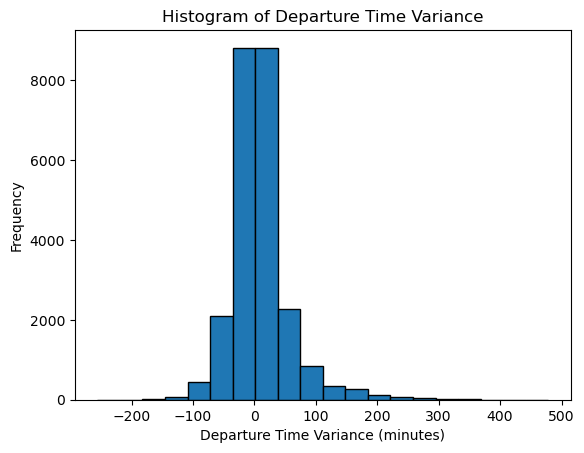

In [16]:
dt = df['Departure Time Variance (minutes)']

# Create a histogram with specified number of bins (you can adjust this)
plt.hist(dt, bins=20, edgecolor='k')

# Add labels and a title
plt.xlabel('Departure Time Variance (minutes)')
plt.ylabel('Frequency')
plt.title('Histogram of Departure Time Variance')

# Show the histogram
plt.show()

Based on these statistics:

The mean departure time variance being positive (8.38 minutes) suggests that, on average, departures tend to be slightly later than planned.

The standard deviation being relatively large (47.49 minutes) indicates a wide spread of departure time variances, with some instances of significant delays and early departures.

The presence of negative values (e.g., minimum of -255.63 minutes) indicates instances where departures occurred earlier than planned.

The maximum departure time variance of 478.35 minutes suggests that there are cases of substantial delays in departures.

In conclucsion I am satisfied with the data quality.

Creating Category for dispatching pattern

In [17]:
# Convert 'Planned Route Start' and 'Actual Route Start' columns to datetime format
df['Planned Route Start'] = pd.to_datetime(df['Planned Route Start'])
df['Actual Route Start'] = pd.to_datetime(df['Actual Route Start'])

# Filter the DataFrame based on date comparison
df = df[df['Planned Route Start'].dt.date == df['Actual Route Start'].dt.date]

# Continue with the calculations and categorizations

# Filter the DataFrame based on date comparison
#df = df[df['Planned Route Start'].dt.date == df['Actual Route Start'].dt.date]

# Calculate 'Departure Time Variance' and 'Departure Time Variance (minutes)'
df['Departure Time Variance'] = df['Actual Route Start'] - df['Planned Route Start']
df['Departure Time Variance (minutes)'] = df['Departure Time Variance'].dt.total_seconds() / 60

# Define the categorization function
def categorize_departure_variance(minutes):
    if minutes <= -120:
        return 'Dispatched 2hrs+ Earlier'
    elif minutes > -120 and minutes <= -60:
        return 'Dispatched 1-2 hrs early'
    elif minutes > -60 and minutes <= -30:
        return 'Dispatched 30min-1hr early'
    elif minutes > -30 and minutes <= 30:
        return 'On Time'
    elif minutes > 30 and minutes <= 60:
        return 'Dispatched 30min-1hr late'
    elif minutes > 60 and minutes < 120:
        return 'Dispatched 1hr-2hrs late'
    else:
        return 'Dispatched 2hrs+ late'

# Apply the custom function to create a new column
df['Dispatch Variance Category'] = df['Departure Time Variance (minutes)'].apply(categorize_departure_variance)

# Display the DataFrame with the new category column
print(df[['Departure Time Variance (minutes)', 'Dispatch Variance Category']])


       Departure Time Variance (minutes)  Dispatch Variance Category
9                             -32.483333  Dispatched 30min-1hr early
10                            -32.483333  Dispatched 30min-1hr early
11                            -32.483333  Dispatched 30min-1hr early
12                            -22.733333                     On Time
13                            -22.733333                     On Time
...                                  ...                         ...
33434                         -38.750000  Dispatched 30min-1hr early
33435                         -38.750000  Dispatched 30min-1hr early
33436                         146.000000       Dispatched 2hrs+ late
33437                         146.000000       Dispatched 2hrs+ late
33438                         146.000000       Dispatched 2hrs+ late

[24254 rows x 2 columns]


In [ ]:
print(df.columns)

In [18]:
# Convert 'Planned Route End' and 'Actual Route End' columns to datetime format
df['Planned Route End'] = pd.to_datetime(df['Planned Route End'])
df['Actual Route End'] = pd.to_datetime(df['Actual Route End'])

# Filter the DataFrame based on date comparison
df = df[df['Planned Route End'].dt.date == df['Actual Route End'].dt.date]

# Calculate 'Depot Return Variance' and 'Depot Return Variance (minutes)'
df['Depot Return Variance'] = df['Actual Route End'] - df['Planned Route End']
df['Depot Return Variance (minutes)'] = df['Depot Return Variance'].dt.total_seconds() / 60

# Define the categorization function
def categorize_departure_variance(minutes):
    if minutes <= -120:
        return 'Returned 2hrs+ Earlier'
    elif minutes > -120 and minutes <= -60:
        return 'Returned 1-2 hrs early'
    elif minutes > -60 and minutes <= -30:
        return 'Returned 30min-1hr early'
    elif minutes > -30 and minutes <= 30:
        return 'On Time'
    elif minutes > 30 and minutes <= 60:
        return 'Returned 30min-1hr late'
    elif minutes > 60 and minutes < 120:
        return 'Returned 1hr-2hrs late'
    else:
        return 'Returned 2hrs+ late'

# Apply the custom function to create a new column
df['Depot Return Variance Category'] = df['Depot Return Variance (minutes)'].apply(categorize_departure_variance)

# Display the DataFrame with the new category column
print(df[['Depot Return Variance (minutes)', 'Depot Return Variance Category']])


       Depot Return Variance (minutes) Depot Return Variance Category
9                          -126.250000         Returned 2hrs+ Earlier
10                         -126.250000         Returned 2hrs+ Earlier
11                         -126.250000         Returned 2hrs+ Earlier
12                          -44.250000       Returned 30min-1hr early
13                          -44.250000       Returned 30min-1hr early
...                                ...                            ...
33434                       145.083333            Returned 2hrs+ late
33435                       145.083333            Returned 2hrs+ late
33436                       271.616667            Returned 2hrs+ late
33437                       271.616667            Returned 2hrs+ late
33438                       271.616667            Returned 2hrs+ late

[23734 rows x 2 columns]


In [19]:
# Convert 'Actual Route End' and 'Actual Route Start' columns to datetime format
df['Actual Route End'] = pd.to_datetime(df['Actual Route End'])
df['Actual Route Start'] = pd.to_datetime(df['Actual Route Start'])

# Convert 'Actual TAT' and 'Planned MST' columns to datetime
df['Actual TAT'] = pd.to_datetime(df['Actual TAT'], errors='coerce')
df['Planned MST'] = pd.to_datetime(df['Planned MST'], errors='coerce')

# Filter the DataFrame to include only rows where 'Actual Route End' and 'Actual Route Start' have the same date
df = df[df['Actual Route End'].dt.date == df['Actual Route Start'].dt.date]

# Calculate 'TAT Variance' and 'TAT Variance (Minutes)'
df['TAT Variance'] = df['Actual TAT'] - df['Planned MST']
df['TAT Variance (Minutes)'] = df['TAT Variance'].dt.total_seconds() / 60

# Filter the DataFrame to keep only rows with TAT Variance greater than or equal to 20 minutes
df = df[df['TAT Variance (Minutes)'] >= 20]

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

def categorize_TA_variance(minutes):
    if minutes > 0 and minutes <= 30:
        return '0 <TAT <=30'
    elif minutes > 30 and minutes <= 60:
        return '30 <TAT <=60'
    elif minutes > 60 and minutes <= 120:
        return '60 <TAT <=120'
    elif minutes > 120 and minutes <= 180:
        return '120 <TAT <=180'
    elif minutes > 180 and minutes <= 240:
        return '180 <TAT <=240'
    else:
        return 'TAT 4hrs +'

# Apply the custom function to create a new column
df['TAT Variance Category'] = df['TAT Variance (Minutes)'].apply(categorize_TA_variance)

print(df[['TAT Variance Category', 'TAT Variance (Minutes)']])






     TAT Variance Category  TAT Variance (Minutes)
0            60 <TAT <=120                   91.75
1              0 <TAT <=30                   24.70
2              0 <TAT <=30                   26.85
3           120 <TAT <=180                  174.50
4           180 <TAT <=240                  204.00
...                    ...                     ...
7644        180 <TAT <=240                  188.00
7645        120 <TAT <=180                  164.00
7646         60 <TAT <=120                   87.40
7647         60 <TAT <=120                   67.50
7648            TAT 4hrs +                  338.50

[7649 rows x 2 columns]


In [ ]:
variance_stats = df['TAT Variance (Minutes)'].describe()
print(variance_stats)

In [ ]:
print(df.columns)

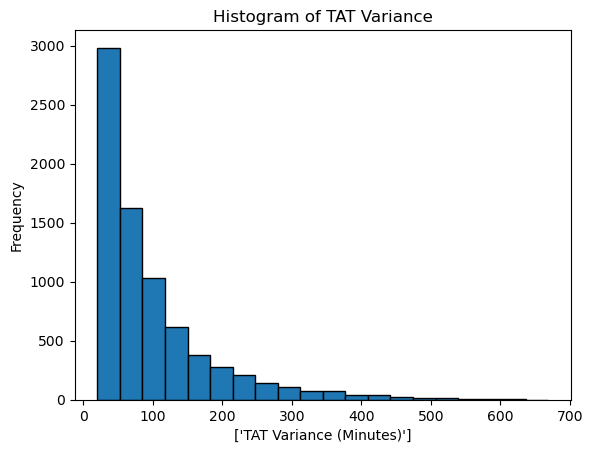

In [20]:
dt = df[['TAT Variance (Minutes)']]

# Create a histogram with specified number of bins (you can adjust this)
plt.hist(dt, bins=20, edgecolor='k')

# Add labels and a title
plt.xlabel(['TAT Variance (Minutes)'])
plt.ylabel('Frequency')
plt.title('Histogram of TAT Variance')

# Show the histogram
plt.show()

In [ ]:
print(df.columns)

In [21]:
df['Driver_Score_Dispatch'] = df['Dispatch Variance Category'].apply(
    lambda x: 3 if x == 'Dispatched 2hrs+ Earlier' else
    (5 if x == 'Dispatched 1-2 hrs early' else
    (10 if x == 'Dispatched 30min-1hr early' else
     (10 if x == 'On Time' else
      (5 if x == 'Dispatched 30min-1hr late' else
       (3 if x == 'Dispatched 1hr-2hrs late' else 1))
    )
    )
))

driver_Dispatch_performance = df.groupby('Driver').agg(
    Number_of_Routes=pd.NamedAgg(column='Dispatch Variance Category', aggfunc='count'),
    Driver_Score_Dispatch=pd.NamedAgg(column='Driver_Score_Dispatch', aggfunc='sum')
)

# Calculate the driver score as a percentage
driver_Dispatch_performance['Driver_Score_Percentage'] = (driver_Dispatch_performance['Driver_Score_Dispatch'] /
                                                  (driver_Dispatch_performance['Number_of_Routes']*10))*100

# Sort the results by the number of routes in descending order
driver_Dispatch_performance = driver_Dispatch_performance.sort_values(by='Number_of_Routes', ascending=False)

# Display the results
print(driver_Dispatch_performance)

                     Number_of_Routes  Driver_Score_Dispatch  \
Driver                                                         
SINDILE TSHAYINYONI               206                   1819   
DAVID NHLANH MZOBE                203                   1618   
LUCKY KHANYILE                    188                   1494   
THANDO MKHIZE                     181                   1559   
Andile Siziba                     177                   1521   
...                               ...                    ...   
XOLANI NENE                         5                     50   
MARK MOODLEY                        4                     26   
GODFREY BUTHELEZI                   4                     23   
DECEMBER MORAJANE                   3                     23   
JABULANI Nkosi                      1                      1   

                     Driver_Score_Percentage  
Driver                                        
SINDILE TSHAYINYONI                88.300971  
DAVID NHLANH MZOBE        

In [22]:
df['Driver_Score_Return'] = df['Depot Return Variance Category'].apply(
    lambda x: 10 if x == 'Returned 2hrs+ Earlier' else
    (10 if x == 'Returned 1-2 hrs early' else
    (10 if x == 'Returned 30min-1hr early' else
     (10 if x == 'On Time' else
      (3 if x == 'Returned 30min-1hr late' else
       (1 if x == 'Returned 1hr-2hrs late' else 0))
    )
    )
))

driver_Return_performance = df.groupby('Driver').agg(
    Number_of_Routes=pd.NamedAgg(column='Depot Return Variance Category', aggfunc='count'),
    Driver_Score_Return=pd.NamedAgg(column='Driver_Score_Return', aggfunc='sum')
)

# Calculate the driver score as a percentage
driver_Return_performance['Driver_Return_Score_Percentage'] = (driver_Dispatch_performance['Driver_Score_Dispatch'] /
                                                  (driver_Dispatch_performance['Number_of_Routes']*10))*100

# Sort the results by the number of routes in descending order
driver_Return_performance = driver_Return_performance.sort_values(by='Number_of_Routes', ascending=False)

# Display the results
print(driver_Return_performance)

 

                     Number_of_Routes  Driver_Score_Return  \
Driver                                                       
SINDILE TSHAYINYONI               206                  125   
DAVID NHLANH MZOBE                203                   78   
LUCKY KHANYILE                    188                  265   
THANDO MKHIZE                     181                  332   
Andile Siziba                     177                   55   
...                               ...                  ...   
XOLANI NENE                         5                   31   
MARK MOODLEY                        4                    1   
GODFREY BUTHELEZI                   4                   11   
DECEMBER MORAJANE                   3                   20   
JABULANI Nkosi                      1                    1   

                     Driver_Return_Score_Percentage  
Driver                                               
SINDILE TSHAYINYONI                       88.300971  
DAVID NHLANH MZOBE             

In [23]:
df['Driver_TAT_Score'] = df['TAT Variance Category'].apply(
    lambda x: 10 if x == '0 <TAT <=30' else
    (8 if x == '30 <TAT <=60' else
    (5 if x == '60 <TAT <=120' else
     (3 if x == '120 <TAT <=180' else
      (1 if x == '180 <TAT <=240' else 0)
    )
    )
))

driver_TAT_performance = df.groupby('Driver').agg(
    Number_of_Routes=pd.NamedAgg(column='TAT Variance Category', aggfunc='count'),
    Driver_Score_TAT=pd.NamedAgg(column='Driver_TAT_Score', aggfunc='sum')
)

# Calculate the driver score as a percentage
driver_TAT_performance['Driver_TAT_Score_Percentage'] = (driver_TAT_performance['Driver_Score_TAT'] /
                                                  (driver_TAT_performance['Number_of_Routes']*10))*100

# Sort the results by the number of routes in descending order
driver_TAT_performance = driver_TAT_performance.sort_values(by='Number_of_Routes', ascending=False)

# Display the results
print(driver_TAT_performance, driver_Return_performance, driver_Dispatch_performance)


                     Number_of_Routes  Driver_Score_TAT  \
Driver                                                    
SINDILE TSHAYINYONI               206              1123   
DAVID NHLANH MZOBE                203              1225   
LUCKY KHANYILE                    188               839   
THANDO MKHIZE                     181               871   
Andile Siziba                     177               998   
...                               ...               ...   
XOLANI NENE                         5                28   
MARK MOODLEY                        4                29   
GODFREY BUTHELEZI                   4                16   
DECEMBER MORAJANE                   3                19   
JABULANI Nkosi                      1                 8   

                     Driver_TAT_Score_Percentage  
Driver                                            
SINDILE TSHAYINYONI                    54.514563  
DAVID NHLANH MZOBE                     60.344828  
LUCKY KHANYILE              

In [24]:
# Calculate the weighted score for each driver in each performance category
driver_TAT_performance['Weighted_Score_TAT'] = (driver_TAT_performance['Driver_TAT_Score_Percentage'] * 0.4)
driver_Return_performance['Weighted_Score_Return'] = (driver_Return_performance['Driver_Return_Score_Percentage'] * 0.3)
driver_Dispatch_performance['Weighted_Score_Dispatch'] = (driver_Dispatch_performance['Driver_Score_Percentage'] * 0.3)

# Combine the three DataFrames into one, using the 'Driver' column as the index
driver_combined_performance = pd.concat([driver_TAT_performance, driver_Return_performance, driver_Dispatch_performance], axis=1)

# Calculate the total weighted score by summing the scores from each category
driver_combined_performance['Total_Weighted_Score'] = (
    driver_combined_performance['Weighted_Score_TAT'] +
    driver_combined_performance['Weighted_Score_Return'] +
    driver_combined_performance['Weighted_Score_Dispatch']
)

# Select the relevant columns for the final DataFrame
weighted_score_df = driver_combined_performance[['Number_of_Routes', 'Total_Weighted_Score']]

# Sort drivers by their total weighted scores in descending order
weighted_score_df = weighted_score_df.sort_values(by='Total_Weighted_Score', ascending=False)

# Reset the index to have a clean index without duplicate driver names
weighted_score_df.reset_index(inplace=True)

# Display the results
print(weighted_score_df)


                 Driver  Number_of_Routes  Number_of_Routes  Number_of_Routes  \
0          HIRESH BAJAN                81                81                81   
1        WEBSTER STUART                21                21                21   
2           Gars Khanye               111               111               111   
3   CHRISTOPHER MUNSAMY                77                77                77   
4         THOMAS SIBIYA                88                88                88   
..                  ...               ...               ...               ...   
85           DANE JAMES                43                43                43   
86      PETROS KHANYILE                50                50                50   
87    GODFREY BUTHELEZI                 4                 4                 4   
88     MFANAFUTHI MSANE                 6                 6                 6   
89       JABULANI Nkosi                 1                 1                 1   

    Total_Weighted_Score  


In [25]:
# Calculate the weighted score for each driver
weighted_score = (
    (driver_TAT_performance['Driver_TAT_Score_Percentage'] * 0.4) +
    (driver_Return_performance['Driver_Return_Score_Percentage'] * 0.3) +
    (driver_Dispatch_performance['Driver_Score_Percentage'] * 0.3)
)

# Create a DataFrame with driver names, weighted scores, and number of routes
weighted_score_df = pd.DataFrame({
    'Driver': driver_TAT_performance.index,  # Use the index (driver names) as the 'Driver' column
    'Weighted_Score': weighted_score,
    'Number_of_Routes': driver_TAT_performance['Number_of_Routes']  # Add the number of routes
})

# Sort drivers by their weighted scores
weighted_score_df = weighted_score_df.sort_values(by='Weighted_Score', ascending=False)

# Display the results
print(weighted_score_df)


                                  Driver  Weighted_Score  Number_of_Routes
Driver                                                                    
HIRESH BAJAN                HIRESH BAJAN       91.234568                81
WEBSTER STUART            WEBSTER STUART       86.952381                21
 Gars Khanye                 Gars Khanye       86.720721               111
CHRISTOPHER MUNSAMY  CHRISTOPHER MUNSAMY       86.441558                77
THOMAS SIBIYA              THOMAS SIBIYA       85.840909                88
...                                  ...             ...               ...
DANE JAMES                    DANE JAMES       55.441860                43
PETROS KHANYILE          PETROS KHANYILE       50.640000                50
GODFREY BUTHELEZI      GODFREY BUTHELEZI       50.500000                 4
MFANAFUTHI MSANE        MFANAFUTHI MSANE       44.666667                 6
JABULANI Nkosi            JABULANI Nkosi       38.000000                 1

[90 rows x 3 columns]
